<a href="https://colab.research.google.com/github/JairsonAlbertoSami/desafio-junior-data-scientis/blob/main/visualizacao_Analise_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [251]:
# Instala BigQuery e basedosdados

!pip install google-cloud-bigquery
!pip install basedosdados

In [252]:
import basedosdados as bd
import pandas as pd
import plotly.express as px
from shapely import wkt
import matplotlib.pyplot as plt

In [253]:
project_id = "datariojairson"

In [254]:
from google.colab import auth
auth.authenticate_user()

# **Localização de chamados do 1746**

Utilize a tabela de Chamados do 1746 e a tabela de Bairros do Rio de Janeiro para as perguntas de 1-5.




# 1. **Quantos chamados foram abertos no dia 01/04/2023?**

In [255]:
data_especifica = '2023-04-01'

consulta_sql = f"""
SELECT *
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE DATE(data_inicio) = '{data_especifica}'
"""

df_chamados = bd.read_sql(consulta_sql, billing_project_id=project_id)

Downloading: 100%|██████████| 1756/1756 [00:01<00:00, 1463.83rows/s]


In [256]:
df_chamados.head(2)

,id_chamado,id_origem_ocorrencia,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,...,data_real_diagnostico,tempo_prazo,prazo_unidade,prazo_tipo,dentro_prazo,situacao,tipo_situacao,justificativa_status,reclamacoes,data_particao
0,18516878,11,2023-04-01 10:49:16,2023-04-03 22:37:36,5,1,62026,119,8,RIOLUZ - Companhia Municipal de Energia e Ilum...,...,NaT,<NA>,D,F,No prazo,Encerrado,Atendido,None,0,2023-04-01
1,18518304,11,2023-04-01 20:54:06,2023-04-03 23:37:38,5,1,62323,95,8,RIOLUZ - Companhia Municipal de Energia e Ilum...,...,NaT,<NA>,D,F,No prazo,Encerrado,Atendido,None,0,2023-04-01


In [257]:
df_chamado_0104 = df_chamados[df_chamados['data_inicio'].dt.date == pd.to_datetime('2023-04-01').date()]
contagem_chamados_hora = df_chamado_0104['data_inicio'].dt.hour.value_counts().sort_index()

In [258]:
df_plotly = pd.DataFrame({
    'Hora': contagem_chamados_hora.index,
    'Número de Chamados': contagem_chamados_hora.values
})

fig = px.bar(df_plotly, x='Hora', y='Número de Chamados',
             title='Chamados abertos em 01/04/2023 por hora')

fig.update_layout(
    title_x=0.5,
    width=1300,
    height=600,
    xaxis_tickangle=-45
)

print(f"Foram abertos {len(df_chamado_0104)} chamados no dia 2023-04-01.")

fig.show()

Foram abertos 1756 chamados no dia 2023-04-01.


# 2. **Qual o tipo de chamado que teve mais teve chamados abertos no dia 01/04/2023?**

In [259]:
df_chamado_0104.tipo.value_counts().index[0]

'Estacionamento irregular'

In [260]:
fig = px.bar(df_chamado_0104['tipo'].value_counts()[:10],
             x=df_chamado_0104['tipo'].value_counts()[:10].index,
             y=df_chamado_0104['tipo'].value_counts()[:10].values,
             labels={'x': 'Tipo de Chamado', 'y': 'Número de Chamados'},
             title='Top 10 Tipos de Chamados Mais Frequentes em 01/04/2023')

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=600,
    xaxis_tickangle=-45
)

fig.show()

# **3. Quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?**

In [261]:
# from shapely import wkt
df_dados_mestres = bd.read_sql("SELECT* FROM `datario.dados_mestres.bairro`",
                 billing_project_id = project_id)

df_dados_mestres['geometry'] = df_dados_mestres['geometry'].apply(wkt.loads)

Downloading: 100%|██████████| 164/164 [00:03<00:00, 45.52rows/s]


In [262]:
df_mestre_chamados_merged = pd.merge(df_dados_mestres, df_chamados, on='id_bairro', how='outer')

top_3_bairros_merged = df_mestre_chamados_merged['nome'].value_counts().nlargest(3)

In [263]:
top_3_bairros_merged =top_3_bairros_merged.reset_index()

In [264]:
import geopandas as gpd

bairro_chamados = gpd.GeoDataFrame(df_mestre_chamados_merged, geometry='geometry', crs='epsg:4326')
bairro_mais_chamados = bairro_chamados[bairro_chamados['nome'].isin(top_3_bairros_merged['index'])]

In [265]:
bairro_chamados['Mapa RJ'] = 'juntar'

In [266]:
rj_map =bairro_chamados.dissolve(by='Mapa RJ')

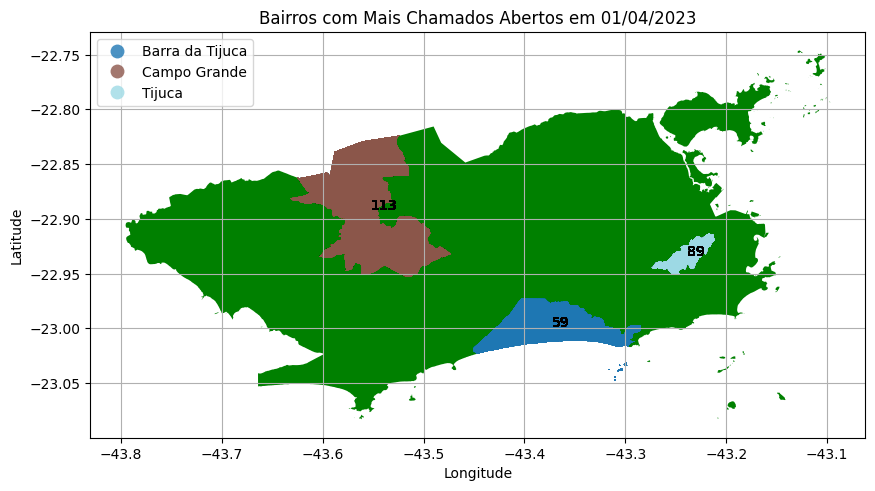

In [267]:
fig, ax = plt.subplots(figsize=(10, 10))
rj_map.plot(ax=ax, color = 'green',  label='Rio de Janeiro')
ax.set_title('Bairros com Mais Chamados Abertos em 01/04/2023')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

bairro_mais_chamados.plot(legend=True, column='nome',
                            categorical=True,
                            legend_kwds={'loc': 'upper left'},
                            cmap='tab20',
                            ax=ax,alpha = 0.8)
ax.grid(True)

nome_counts = bairro_mais_chamados['nome'].value_counts()
for x, y, label in zip(bairro_mais_chamados.geometry.centroid.x,
                       bairro_mais_chamados.geometry.centroid.y,
                       nome_counts[bairro_mais_chamados['nome']]):
  ax.text(x, y, f"{label}", fontsize=10)

plt.show()

# 4. **Qual o nome da subprefeitura com mais chamados abertos nesse dia?**

In [268]:
top_subprefeituras = df_mestre_chamados_merged['subprefeitura'].value_counts()

fig = px.bar(top_subprefeituras,
             x=top_subprefeituras.index,
             y=top_subprefeituras.values,
             labels={'x': 'Subprefeitura', 'y': 'Número de Chamados'},
             title='Número de Chamados por Subprefeitura em 01/04/2023')
fig.update_layout(
    title_x=0.5,
    width=1000,
    height=600,
    xaxis_tickangle=-45
)
fig.show()

# 5. **Existe algum chamado aberto nesse dia que não foi associado a um bairro ou subprefeitura na tabela de bairros? Se sim, por que isso acontece?**

In [269]:
df_dados_mestres_sem_subprefei = df_mestre_chamados_merged[df_mestre_chamados_merged['subprefeitura'].isnull()]
num_df_dados_mestres_sem_subprefei = df_dados_mestres_sem_subprefei.shape[0]
fig = px.pie(values=[num_df_dados_mestres_sem_subprefei, df_mestre_chamados_merged.shape[0] - num_df_dados_mestres_sem_subprefei],
             names=['Sem Subprefeitura', 'Com Subprefeitura'],
             title='Chamados com e sem Subprefeitura Associada')
fig.update_layout(
    title_x=0.5,
    width=600,
    height=400
)
fig.show()

# **Chamados do 1746 em grandes eventos**

Utilize a tabela de Chamados do 1746 e a tabela de Ocupação Hoteleira em Grandes Eventos no Rio para as perguntas de 6-10. Para todas as perguntas considere o subtipo de chamado "Perturbação do sossego


In [270]:
data_fim = '2023-12-31'
data_inicio = '2022-01-01'

consulta_sql = f"""
SELECT *
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE DATE(data_inicio) BETWEEN '{data_inicio}' AND '{data_fim}'
"""

df_chamados_grandes_eventos = bd.read_sql(consulta_sql, billing_project_id=project_id)

Downloading: 100%|██████████| 1634336/1634336 [10:00<00:00, 2719.73rows/s]


# 6. **Quantos chamados com o subtipo "Perturbação do sossego" foram abertos desde 01/01/2022 até 31/12/2023 (incluindo extremidades)?**

In [271]:
df_pertubacao_sossego = df_chamados_grandes_eventos[df_chamados_grandes_eventos["subtipo"].str.contains("Perturbação do sossego")]
inicio = pd.to_datetime('2022-01-01')
fim = pd.to_datetime('2023-12-31')
df_filtrado = df_pertubacao_sossego[(df_pertubacao_sossego['data_inicio'] >= inicio) & (df_pertubacao_sossego['data_inicio'] <= fim)]

contagem_chamados_por_mes = df_filtrado.groupby(pd.Grouper(key='data_inicio', freq='M')).size()


fig = px.line(x=contagem_chamados_por_mes.index, y=contagem_chamados_por_mes.values,
              labels={'x': 'Mês', 'y': 'Número de Chamados'},
              title='Número de Chamados "Perturbação do Sossego" por Mês (2022-2023)')

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=600,
    xaxis_tickangle=-45
)

print(f"Entre o começo de 2022 e o final de 2023, foram registrados {df_filtrado.shape[0]} chamados relacionados à 'Perturbação do sossego'.")

fig.show()

Entre o começo de 2022 e o final de 2023, foram registrados 42830 chamados relacionados à 'Perturbação do sossego'.


# 7. **Selecione os chamados com esse subtipo que foram abertos durante os eventos contidos na tabela de eventos (Reveillon, Carnaval e Rock in Rio).**

In [272]:
df_eventos = bd.read_sql("SELECT* FROM `datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos`",
                 billing_project_id = project_id)

df_eventos['data_inicial'] = pd.to_datetime(df_eventos['data_inicial'])
df_eventos['data_final'] = pd.to_datetime(df_eventos['data_final'])

Downloading: 100%|██████████| 8/8 [00:00<00:00, 45.38rows/s]


In [273]:
df_eventos.drop_duplicates(inplace=True)
df_eventos.sort_values(by='evento', inplace=True)

In [274]:
df_eventos.loc[df_eventos.index[2], 'evento'] = 'Rock in Rio - 2022-09-02'
df_eventos.loc[df_eventos.index[3], 'evento'] = 'Rock in Rio - 2022-09-08'

In [275]:
def encontrar_evento(row):
    for _, evento in df_eventos.iterrows():
        if evento['data_inicial'] <= row['data_inicio'] <= evento['data_final']:
            return evento['evento']
        if pd.notna(row['data_fim']) and evento['data_inicial'] <= row['data_fim'] <= evento['data_final']:
            return evento['evento']
    return None

df_pertubacao_sossego['evento'] = df_pertubacao_sossego.apply(encontrar_evento, axis=1)

In [276]:
df_pertubacao_sossego['evento'].value_counts()

,evento
Rock in Rio - 2022-09-08,1127
Rock in Rio - 2022-09-02,364
Reveillon,231
Carnaval,216


In [277]:
eventos_desejados = ['Carnaval', 'Reveillon', 'Rock in Rio - A', 'Rock in Rio - 2022-09-02', 'Rock in Rio - 2022-09-08']

df_chamados_eventos = df_pertubacao_sossego[df_pertubacao_sossego['evento'].isin(eventos_desejados)]
print(f'Foram no total {len(df_chamados_eventos)} chamados nos eventos: Carnaval, Reveillon, Rock in Rio')

contagem_chamados = df_chamados_eventos['evento'].value_counts()

fig = px.pie(values=contagem_chamados.values,
             names=contagem_chamados.index,
             title='Distribuição de Chamados por Evento')

fig.update_layout(
    title_x=0.5,
    width=600,
    height=400
)


fig.show()

Foram no total 1938 chamados nos eventos: Carnaval, Reveillon, Rock in Rio


# 9. **Qual evento teve a maior média diária de chamados abertos desse subtipo?**

In [278]:
df_eventos['duracao'] = (df_eventos['data_final'] - df_eventos['data_inicial']).dt.days + 1
media_diaria_por_evento = df_chamados_eventos['evento'].value_counts() / df_eventos.set_index('evento')['duracao']

media_diaria_por_evento_ordenada = media_diaria_por_evento.sort_values(ascending=False)

In [279]:
cores = ['red', 'blue', 'green']

fig = px.bar(media_diaria_por_evento_ordenada,
             x=media_diaria_por_evento_ordenada.index,
             y=media_diaria_por_evento_ordenada.values,
             labels={'x': 'Evento', 'y': 'Média Diária de Chamados'},
             title='Média Diária de Chamados "Perturbação do Sossego" por Evento',
             color=media_diaria_por_evento_ordenada.index,
             color_discrete_sequence=cores
            )

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=600,
    xaxis_tickangle=-45
)

fig.show()


# 10. **Compare as médias diárias de chamados abertos desse subtipo durante os eventos específicos (Reveillon, Carnaval e Rock in Rio) e a média diária de chamados abertos desse subtipo considerando todo o período de 01/01/2022 até 31/12/2023.**